# Tasks:
1. Find a proper train test split
2. Implement a model for the segmentation task.
    - Find a proper loss function & explain the choice
    - Provide the implementation of the model architecture, dataloader & training method
    - Show that your implementation is working - one or two epochs are enough

3. Extend your pipeline to create a flip-robust segmentation
    - Add a second loss function, explain why this can be helpful and explain your choice
    - Add a flip augmentation
    - Show that your implementation is working - again one or two epochs are fine

About the datasets: (source : Continual Hippocampus Segmentation with Transformers)
1. Dryad: contains 50 cases of healthy patients
2. HarP: The Harmonized Hippocampal Protocol dataset, which we refer to as HarP, contains healthy subjects and patients with Alzheimer’s disease.

I will be using the Dryad dataset for this task.

In [235]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import os
import glob
import nibabel as nib


### Loading the dataset

In [236]:
# Define a function to load and preprocess data for a single case
def load_and_preprocess_case(data_dir, case_name):
    # Construct the file paths for image and mask
    image_file = os.path.join(data_dir, f"{case_name}.nii.gz")
    mask_file = os.path.join(data_dir, f"{case_name}_gt.nii.gz")
    
    # Load MRI image data
    img_data = nib.load(image_file).get_fdata()
    
    # Load the corresponding ground truth segmentation mask
    mask_data = nib.load(mask_file).get_fdata()
    
    # Preprocess data as needed (e.g., resize, normalize)
    # You may need to adapt this preprocessing based on your data
    
    return img_data, mask_data

In [237]:
# Define a function to load and preprocess the entire dataset
def load_and_preprocess_dataset(dataset_dir):
    data = []
    labels = []
    
    # Iterate through each case name
    case_names = [f"s{str(i).zfill(2)}_{hemi}" for i in range(1, 26) for hemi in ['L', 'R']]
    
    for case_name in case_names:
        img_data, mask_data = load_and_preprocess_case(dataset_dir, case_name)
        
        if img_data is not None and mask_data is not None:
            data.append(img_data)
            labels.append(mask_data)
    
    return data, labels

In [238]:
# Specify the path to the "Dryad" dataset directory
dryad_dataset_dir = 'datasets/Dryad'

# Load and preprocess the "Dryad" dataset
dryad_data, dryad_labels = load_and_preprocess_dataset(dryad_dataset_dir)

### Understanding the dataset and the MRI scans

In [239]:
# print dryad_data and dryad_labels
print(len(dryad_data))
print(len(dryad_labels))

50
50


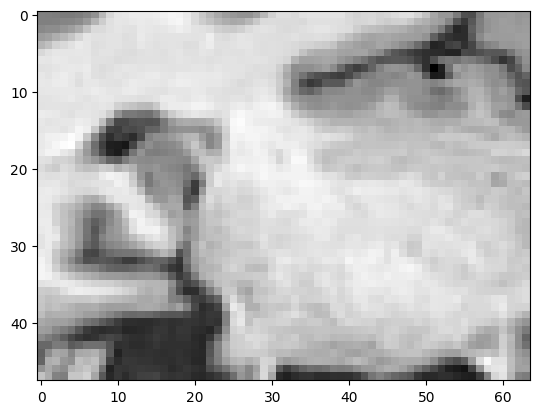

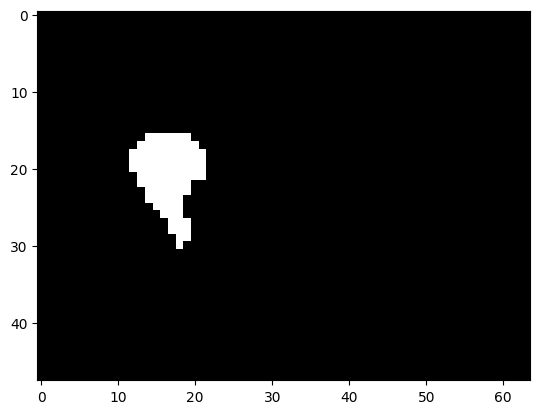

In [240]:
# visualise the images and corresponsing mask for a single case as an image
import matplotlib.pyplot as plt
plt.imshow(dryad_data[2][:,:,30], cmap='gray')
plt.show()
plt.imshow(dryad_labels[2][:,:,30], cmap='gray')
plt.show()

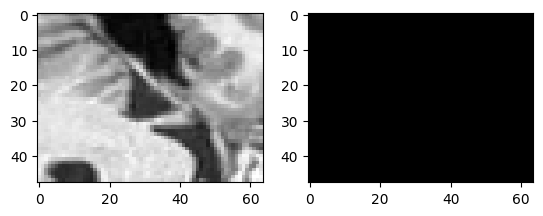

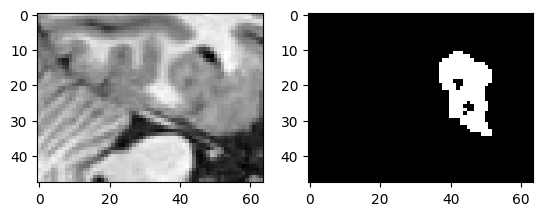

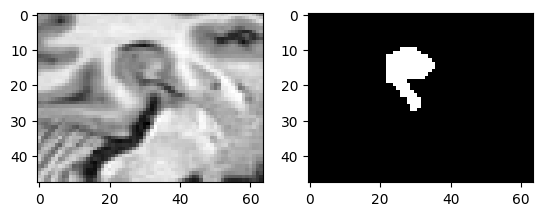

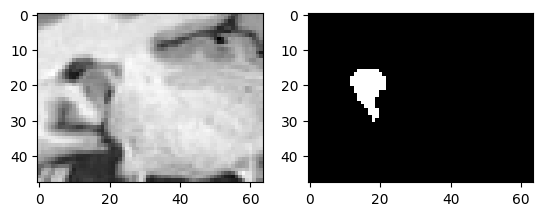

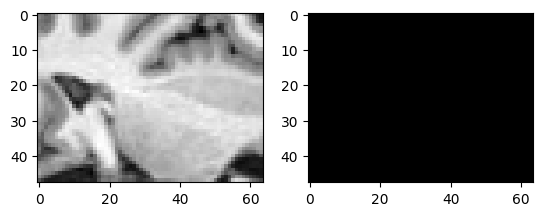

In [241]:
# Specify the range of slices you want to visualize
start_slice = 0
end_slice = 50  # Adjust this based on your data

# Loop through and display the slices and corresponding masks side by side
for slice_num in range(start_slice, end_slice,10):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(dryad_data[2][:, :, slice_num], cmap='gray')
    axarr[1].imshow(dryad_labels[2][:, :, slice_num], cmap='gray')
    plt.show()

### Implement a model for the segmentation task

In [242]:
# determining the shape of the data
print(dryad_data[0][0].shape)
print(dryad_labels[0].shape)

(64, 64)
(48, 64, 64)


(48, 64, 64)


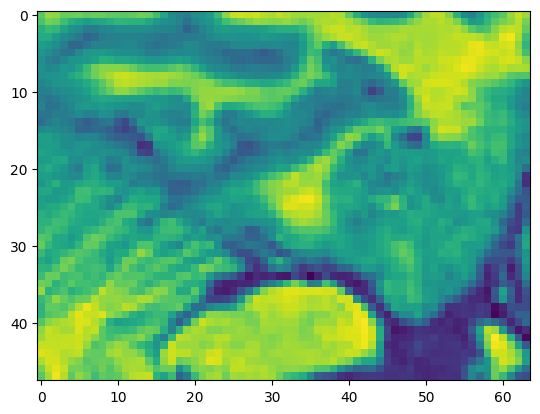

Number of input channels: 64


In [243]:
# Load a .nii.gz file
img = nib.load('datasets/Dryad/s01_L.nii.gz')
# Get the image data
img_data = img.get_fdata()
print(img_data.shape)   # (48,64,64)

slice1=(img_data[47,:,:,])
slice2=(img_data[:,50,:])
slice3=(img_data[:,:,10])

plt.figure()
plt.imshow(slice1)
plt.imshow(slice2)
plt.imshow(slice3)
plt.show()

#---------------------------------------------

# Check the number of dimensions in the data array
num_channels = img_data.shape[-1]

print(f"Number of input channels: {num_channels}")

In [244]:
'''DoubleConv is a custom module that defines a block with two convolutional layers followed by batch normalization and ReLU activation.
It's used to create a pair of convolutional layers with normalization and activation.'''
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
'''DownBlock is a custom module that represents the downsampling (contracting) path of the U-Net.
It consists of a DoubleConv block followed by a max-pooling operation to reduce the spatial resolution.
It takes an input tensor, applies convolution and pooling, and returns two outputs: the downsampled feature map and the original 
feature map before downsampling.'''   
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

# class UpBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, up_sample_mode):
#         super(UpBlock, self).__init__()
#         if up_sample_mode == 'conv_transpose':
#             self.up_sample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)  # Use in_channels and out_channels here
#         elif up_sample_mode == 'bilinear':
#             self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         else:
#             raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
#         self.double_conv = DoubleConv(in_channels, out_channels)

#     def forward(self, down_input, skip_input):
#         x = self.up_sample(down_input)
#         x = torch.cat([x, skip_input], dim=1)
#         return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, in_channels, out_classes, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(64 + in_channels, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [245]:
# # Customize the number of input channels and output classes based on your dataset
in_channels = 48  # Adjust this to match your data
out_classes = 2  # Adjust this for your segmentation task

# Get UNet model
model = UNet(in_channels,out_classes)

In [246]:
# Define your custom dataset class for loading and preprocessing data
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'image': self.data[idx], 'mask': self.labels[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [247]:
# Define the Dice loss function
def dice_loss(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target)
    dice = (2 * intersection) / (union + 1e-5)  # Add epsilon for numerical stability
    return 1 - dice

In [248]:
# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(dryad_data, dryad_labels, test_size=0.3, random_state=42)

# Create data loaders for training and testing
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=6)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = dice_loss  # You can use BCE loss as well

In [249]:
# Training loop
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, masks = batch['image'].to(device).float(), batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

RuntimeError: Given transposed=1, weight of size [48, 48, 2, 2], expected input[6, 128, 32, 32] to have 48 channels, but got 128 channels instead

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, masks = batch['image'].to(device), batch['mask'].to(device)
        outputs = model(inputs)

        loss = criterion(outputs, masks)

    print(f'Loss: {loss.item()}')